<a href="https://colab.research.google.com/github/jarvez31/Object_representation_model/blob/main/Moser_code_graph_FF_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SETUP

### Install the extra modules

In [ ]:
###############------------------- FOR AZRA ---------------------#############

!pip install -q tensorflow-model-optimization
!pip install -q unrar 
!pip install -q keras_bert
!pip install -q google.colab 
# !pip install -q keras-gcn
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
data_fol = "/content/drive/MyDrive/sachin_deshmukh_proj/LEC_MEC_CA/"
# data_fol = "/content/drive/MyDrive/sachin_deshmukh_proj/StripedData/"

from tensorflow.keras.models import model_from_yaml, model_from_json
from tensorflow import keras
import pickle, shapely
import numpy as np
import math as mt
import tempfile
import tensorflow as tf
import pickle
from scipy import misc
import glob, csv
from tensorflow.keras import layers
from shapely.geometry import box, Polygon, Point, LinearRing
#from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Reshape, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D, concatenate, Concatenate
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K  
# from keras_gcn import GraphConv
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
from sklearn import preprocessing
from numpy import linalg as LA
import pandas as pd
from tensorflow.keras.utils import plot_model
from numpy import matlib
import tensorflow_model_optimization as tfmot
from matplotlib import cm
main = "/content/drive/MyDrive/sachin_deshmukh_proj/"

Mounted at /content/drive


### Setup Parameters

In [ ]:
#@title Folder for storage and trajectory name
fol1 = "new_graph" #@param {type:"string"}
traj1 = "traj_wo_20k.pk1" #@param {type:"string"}
imgs = "frames_traj(wo)_bw_20k.pk1" #@param {type:"string"}
# test_p =  7#@param {type:"number"}
# img_fol = "traj_four_objs_diffW" #@param {type:"string"}

#@markdown ### Standard deviation for population code for x,y
std_dev =  0.3 #@param {type:"slider", min:0, max:1, step:0.1}

#@markdown ### Model Params
Retrain = False #@param {type:"boolean"}
Train = True #@param {type:"boolean"}
Analysis = True #@param {type:"boolean"}
pre_conv = True #@param {type:"boolean"}
obj_pres = True #@param {type:"boolean"}
pi_use = "no_osc" #@param ["osc", "no_osc"]
act_func = "relu" #@param {type:"string"}
learn_rate = 0.0001 #@param {type:"number"}
random_state = 42 #@param {type:"number"}

### Functions

In [ ]:
def rew(x, y, theta, objs, obj_boun, env, env_boun, present=False):
  reward = []
  # obj = k2
  # obj_boun = k3
  for i in range(len(x)): 
    if present:
      if present:
        for pp in range(len(objs)):
          k2 = obj[pp]
          k3 = obj_boun[pp]
          if((max(k3)[0] >= x[i] >= max(k2)[0]) and (max(k2)[1] >= y[i] >= min(k2)[1]) and (90 < theta[i] < 270)):
            reward.append(1)
          elif((min(k3)[0] <= x[i] <= min(k2)[0]) and (max(k2)[1] >= y[i] >= min(k2)[1]) and (90>theta[i] or theta[i]>270)):
            reward.append(1)
          elif((min(k3)[1] <= y[i] <= min(k2)[1]) and (max(k2)[0] >= x[i] >= min(k2)[0]) and (180>theta[i]>0 )):
            reward.append(1)
          elif((max(k3)[1] >= y[i] >= max(k2)[1]) and (max(k2[0]) >= x[i] >= min(k2)[0]) and (360>theta[i]>180)):
            reward.append(1)

          elif((min(k3)[0] <= x[i] <= min(k2)[0]) and (max(k3)[1] >= y[i] >= max(k2)[1]) and (15>theta[i] or theta[i]>255)):
            reward.append(1)
          elif((min(k3)[0] <= x[i] <= min(k2)[0]) and (min(k3)[1] <= y[i] <= min(k2[1])) and (105>theta[i] or theta[i]>335)):
            reward.append(1)
          elif((max(k3)[0] >= x[i] >= max(k2)[0]) and (min(k3)[1] <= y[i] <= min(k2)[1]) and (195>theta[i]>75)):
            reward.append(1)
          elif((max(k3)[0] >= x[i] >= max(k2)[0]) and (max(k3)[1] >= y[i] >= max(k2)[1]) and (285>theta[i]>165)):
            reward.append(1)

      if len(reward) != i+1:
        if((max(k1_env[0]) >= x[i] >= max(k1)[0]) and (90>theta[i] or theta[i]>270)):
          reward.append(0)
        elif((min(k1_env[0]) <= x[i] <= min(k1)[0]) and (270>theta[i]>90)):
          reward.append(0)  
        elif((max(k1_env[1]) >= y[i] >= max(k1)[1]) and (180>theta[i]>0)):
          reward.append(0)
        elif((min(k1_env)[1] <= y[i] <= min(k1)[1]) and (360>theta[i]>180)):
          reward.append(0)
        elif len(reward) != i+1:
            reward.append(0)
      
    else:
      if((max(k1_env[0]) >= x[i] >= max(k1)[0]) and (90>theta[i] or theta[i]>270)):
        reward.append(0)
      elif((min(k1_env[0]) <= x[i] <= min(k1)[0]) and (270>theta[i]>90)):
        reward.append(0)  
      elif((max(k1_env[1]) >= y[i] >= max(k1)[1]) and (180>theta[i]>0)):
        reward.append(0)
      elif((min(k1_env)[1] <= y[i] <= min(k1)[1]) and (360>theta[i]>180)):
        reward.append(0)
      elif len(reward) != i+1:
          reward.append(0)
    
  reward = np.asarray(reward)

  return reward


#%% HD
def HD(s, t):
    with open(main + 'hd_som_wt2.pk1', 'rb') as k:
        wt2 = pickle.load(k)
    
    # phase1d = np.zeros((100, 1))
    PI2d = np.zeros((10, 10))
    k = PI2d.shape  
    trj_hd_resp = []

    for j in range(len(s)):
        if (j%10000 == 0):
            print(j)
        X1 = [mt.cos(mt.radians(t[0])), mt.sin(mt.radians(t[0]))]
        X2 = [mt.cos(mt.radians(t[j])), mt.sin(mt.radians(t[j]))]
        s1 = X2[0]*X1[1] - X1[0]*X2[1]
        s2 = X2[0]*X1[0] + X1[1]*X2[1]
        # print(s2)
        X = [s1, s2]
        y_p = repsom2dlinear(X, wt2)
        trj_hd_resp.append(y_p)
    print("HD response computed")
    return trj_hd_resp

#%%
def PI(resp, s):
    X, Y, theta = np.zeros((100,1)), np.ones((100,1)), [[0]*100] 
    bf = 2*6*mt.pi
    dt = np.divide(1, 100)
    betaa, t, Xbg, Ybg = 50, 0, 1, 0
    tarr = []
    for ii in range(1,len(resp)):
        if (ii%10000 == 0):
            print(ii)
        

        y_q = resp[ii]
        inp1d = np.reshape(np.transpose(y_q),(100,1))
        theta_dot = [(bf + betaa * s[ii] * k[0] * 10) for k in inp1d]
        theta_dot[:] = [x*dt for x in theta_dot]
        theta.append([i+j for i,j in zip(theta[ii-1], theta_dot)])

    theta = np.transpose(np.asarray(theta))
    # print(theta.shape)
    Xarr = np.cos(theta)
    PI1d = Xarr
    return PI1d


def repsom2dlinear(x, wt):
    sz_wt = list(wt.shape)
    y = np.zeros((sz_wt[0], sz_wt[1]))
    if(sz_wt[2] != len(x)):
        print('Invalid input size in repsom2d()\n')
        return

    for i in range(sz_wt[0]):
        for j in range(sz_wt[1]):
            v = wt[i][j].reshape(sz_wt[2], 1)    
            # print(v)
            y[i][j] =  np.dot(x,v)
    return y


def unitvec(pos_corr):
    temp1 = np.subtract(pos_corr[1:, :], pos_corr[:-1, :])
    temp2 = np.sqrt((temp1*temp1).sum(axis=1))
    temp3 = temp1 / temp2.reshape(temp1.shape[0],1)
    return temp3


def relu(input):
    if input > 0:
	    return input
    else:
	    return 0


def test_train(dat, p):
  train_dat = np.asarray([dat[k] for k in range(len(dat)) if not k%p==0])
  test_dat = np.asarray([dat[k] for k in range(len(dat)) if k%p==0])
  return [train_dat, test_dat]


def mse(data, pred_data):
  mse_ = np.sum(np.square(data - pred_data))/len(data)
  return mse_


def seq_data(data, seq_len):
  temp1 = []

  for i in range(seq_len, data.shape[0]):
    temp3 = data[i-seq_len:i]
    temp1.append(temp3)
  temp1 = np.asarray(temp1)
  
  return temp1


class FF(tf.keras.layers.Layer):

    def __init__(self, units, **kwargs):
        super(FF, self).__init__(**kwargs)
        self.units = units
        self.state_size = units
        self.j_h = tf.keras.layers.Dense(self.units)
        self.j_x = tf.keras.layers.Dense(self.units)
        self.k_h = tf.keras.layers.Dense(self.units)
        self.k_x = tf.keras.layers.Dense(self.units)

    def build(self, input_shape):
        self.built = True

    def get_config(self):
        return {'units': self.units}
        
    def call(self, inputs, states):
        #print("FF:", inputs, states)
        prev_output = states[0]
        j = tf.sigmoid(self.j_x(inputs) + self.j_h(prev_output))
        k = tf.sigmoid(self.k_x(inputs) + self.k_h(prev_output))
        output = j * (1 - prev_output) + (1 - k) * prev_output
        return output, [output]

def firing_rate_map(firposgrid, ot, firr, title):
    res = 45
    #firr = list(firr[0])
    x = np.arange(-1, 1, 1/res)
    y = np.arange(-1, 1, 1/res)
    fx,fy = np.meshgrid(x, y)
    firingmap = np.zeros(fx.shape)
    #gridpoint_x = np.asarray(np.reshape(fx, np.size(fx), 1))
    #gridpoint_y = np.asarray(np.reshape(fx, np.size(fx), 1))
    #gridpoint = np.transpose([gridpoint_x, gridpoint_y])
    #roundinggridpoint = np.round(gridpoint)
    #firposround = np.round(firposgrid)
    firingvalue = ot[firr]
    for ii in range(len(firposgrid)):
        q1 = np.argmin(abs(firposgrid[ii,0] - fx[1,:]))
        q2 = np.argmin(abs(firposgrid[ii,1] - fx[1,:]))
        firingmap[q1,q2] = firingvalue[ii]
    firingmap = firingmap/max(np.max(firingmap),1)
    gaussian = matlab_style_gauss2D([10, 10], 1.5)
    spikes_smooth = scipy.signal.convolve2d(gaussian, firingmap) 
    rotated_img = ndimage.rotate(spikes_smooth, 1*270)
    #np.rot90([spikes_smooth], 2)
    plt.imshow(rotated_img, origin= 'upper')
    plt.title(title)
    plt.colorbar()
    ax=plt.gca()                            # get the axis
    ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis
    ax.set_xlim(ax.get_xlim()[::-1])        # invert the axis
    ax.xaxis.tick_bottom()                     # and move the X-Axis    
    ax.set_yticklabels([])
    ax.set_xticklabels([])
  
def matlab_style_gauss2D(shape,sigma):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

class GraphLayer(keras.layers.Layer):

    def __init__(self,
                 step_num=1,
                 activation=None,
                 **kwargs):
        """Initialize the layer.
        :param step_num: Two nodes are considered as connected if they could be reached in `step_num` steps.
        :param activation: The activation function after convolution.
        :param kwargs: Other arguments for parent class.
        """
        self.supports_masking = True
        self.step_num = step_num
        self.activation = keras.activations.get(activation)
        self.supports_masking = True
        super(GraphLayer, self).__init__(**kwargs)

    def get_config(self):
        config = {
            'step_num': self.step_num,
            'activation': self.activation,
        }
        base_config = super(GraphLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def _get_walked_edges(self, edges, step_num):
        """Get the connection graph within `step_num` steps
        :param edges: The graph in single step.
        :param step_num: Number of steps.
        :return: The new graph that has the same shape with `edges`.
        """
        if step_num <= 1:
            return edges
        deeper = self._get_walked_edges(K.batch_dot(edges, edges), step_num // 2)
        if step_num % 2 == 1:
            deeper += edges
        return K.cast(K.greater(deeper, 0.0), K.floatx())

    def call(self, inputs, **kwargs):
        features, edges = inputs
        edges = K.cast(edges, K.floatx())
        if self.step_num > 1:
            edges = self._get_walked_edges(edges, self.step_num)
        outputs = self.activation(self._call(features, edges))
        return outputs

    def _call(self, features, edges):
        raise NotImplementedError('The class is not intended to be used directly.')


class GraphConv(GraphLayer):
    r"""Graph convolutional layer.
    h_i^{(t)} = \sigma \left ( \frac{ G_i^T (h_i^{(t - 1)} W + b)}{\sum G_i}  \right )
    """

    def __init__(self,
                 units,
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=None,
                 kernel_constraint=None,
                 use_bias=True,
                 bias_initializer='zeros',
                 bias_regularizer=None,
                 bias_constraint=None,
                 **kwargs):
        """Initialize the layer.
        :param units: Number of new states. If the input shape is (batch_size, node_num, feature_len), then the output
                      shape is (batch_size, node_num, units).
        :param kernel_initializer: The initializer of the kernel weight matrix.
        :param kernel_regularizer: The regularizer of the kernel weight matrix.
        :param kernel_constraint:  The constraint of the kernel weight matrix.
        :param use_bias: Whether to use bias term.
        :param bias_initializer: The initializer of the bias vector.
        :param bias_regularizer: The regularizer of the bias vector.
        :param bias_constraint: The constraint of the bias vector.
        :param kwargs: Other arguments for parent class.
        """
        self.units = units
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.kernel_constraint = keras.constraints.get(kernel_constraint)
        self.use_bias = use_bias
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)
        self.bias_constraint = keras.constraints.get(bias_constraint)

        self.W, self.b = None, None
        super(GraphConv, self).__init__(**kwargs)

    def get_config(self):
        config = {
            'units': self.units,
            'kernel_initializer': keras.initializers.serialize(self.kernel_initializer),
            'kernel_regularizer': keras.regularizers.serialize(self.kernel_regularizer),
            'kernel_constraint': keras.constraints.serialize(self.kernel_constraint),
            'use_bias': self.use_bias,
            'bias_initializer': keras.initializers.serialize(self.bias_initializer),
            'bias_regularizer': keras.regularizers.serialize(self.bias_regularizer),
            'bias_constraint': keras.constraints.serialize(self.bias_constraint),
        }
        base_config = super(GraphConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def build(self, input_shape):
        feature_dim = int(input_shape[0][-1])
        self.W = self.add_weight(
            shape=(feature_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            name='{}_W'.format(self.name),
        )
        if self.use_bias:
            self.b = self.add_weight(
                shape=(self.units,),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                name='{}_b'.format(self.name),
            )
        super(GraphConv, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return input_shape[0][:2] + (self.units,)

    def compute_mask(self, inputs, mask=None):
        if mask is None:
            mask = [None]
        return mask[0]

    def _call(self, features, edges):
        proj = K.dot(features, self.W)
        if self.use_bias:
            proj += self.b
        if self.step_num > 1:
            edges = self._get_walked_edges(edges, self.step_num)
        # aggr = proj/2
        aggr = tf.math.divide((K.sum(proj, axis=1, keepdims=True) + K.epsilon()), 3)
        # aggr = K.batch_dot(K.permute_dimensions(edges, (0, 2, 1)), proj) \
        #     / (K.sum(edges, axis=2, keepdims=True) + K.epsilon())
        return features + aggr
        # return features


---------------------------------
---------------------------------
---------------------------------

# DATA

### Trajectory

In [ ]:
###--------------------- LOAD TRAJECTORY --------------------###

fol = main + fol1 + "/"
traj = traj1
with open(traj, "rb") as f:
    d = pickle.load(f)
    f.close()
locals().update(d)

x = np.asarray(x)
y = np.asarray(y)
pos = np.column_stack((x,y))
# x = x[:-1]
# y = y[:-1]
# theta = theta[:-1]
env = [(1.0, -1.0), (1.0, 1.0), (-1.0, 1.0), (-1.0, -1.0), (1.0, -1.0)]
obj_c = [(-0.4, -0.4)]#, (0.4, 0.4)]

hf_sz = 0.15
out_bound = 0.25
obj_ver = [(c[0]-hf_sz, c[1]-hf_sz, c[0]+hf_sz, c[1]+hf_sz) for c in obj_c]
print(obj_ver)
obj_ver_outer = [(c[0]-hf_sz-out_bound, c[1]-hf_sz-out_bound, c[0]+hf_sz+out_bound, c[1]+hf_sz+out_bound) for c in obj_c]

sq1_env = box(-1.0, -1.0, 1.0, 1.0)
sq1 = box(-0.8, -0.8, 0.8, 0.8)
sq2 = [box(obj_ver[j][0], obj_ver[j][1], obj_ver[j][2], obj_ver[j][3]) for j in range(len(obj_ver))]
sq3 = [box(obj_ver_outer[k][0], obj_ver_outer[k][1], obj_ver_outer[k][2], obj_ver_outer[k][3]) for k in range(len(obj_ver_outer))]
k1_env = list(sq1_env.exterior.coords)
k1 = list(sq1.exterior.coords)
k2 = [list(l.exterior.coords) for l in sq2]
k3 = [list(ll.exterior.coords) for ll in sq3]

env = [[m[0] for m in k1_env ], [m[1] for m in k1_env ]]
obj = [[[m[0] for m in obji ], [m[1] for m in obji ]] for obji in k2]
obj_boun = [[[m[0] for m in objbi ], [m[1] for m in objbi ]] for objbi in k3]
# env = np.asarray(env)
# obj = np.asarray(obj)

theta = np.asarray(theta)
theta_rad = np.radians(theta)
print(max(theta))
print(len(theta))

## objects to do plotting that show shifting
obj_c_plot = [(0.0, 0.0), (-0.4, -0.4)]#, (0.4, 0.4)]#, (-0.4, 0.4)]#, (-0.4, -0.4), (0.4, -0.4)]
obj_ver_plot = [(c[0]-hf_sz, c[1]-hf_sz, c[0]+hf_sz, c[1]+hf_sz) for c in obj_c_plot]
sq2_plot = [box(obj_ver_plot[j][0], obj_ver_plot[j][1], obj_ver_plot[j][2], obj_ver_plot[j][3]) for j in range(len(obj_ver_plot))]
k2_plot = [list(l.exterior.coords) for l in sq2_plot]
obj_plot = [[[m[0] for m in obji ], [m[1] for m in obji ]] for obji in k2_plot]

###--------------------- CREATING GROUND TRUTH(TRAJECTORY) --------------------###

# std_dev = 0.2
# Hd_rep = np.asarray([np.sin(np.deg2rad(theta)), np.cos(np.deg2rad(theta))]).T
# print(pos[:4,:])
# Hd_rep = unitvec(pos)
# print(np.sqrt((Hd_rep*Hd_rep).sum(axis=1)))
# out = 11
# xmat = np.matlib.repmat(x.reshape((len(x),1)),1,out)
# ymat = np.matlib.repmat(y.reshape((len(y),1)),1,out)

# xi = np.asarray(np.matlib.repmat(np.linspace(np.amin(env)-0.4,np.amax(env)+0.4,num=out, endpoint=True), len(x),1))
# yi = np.asarray(np.matlib.repmat(np.linspace(np.amin(env)-0.4,np.amax(env)+0.4,num=out, endpoint=True), len(y),1))

# x_rep = np.exp(-1*((xi-xmat)/std_dev)**2)
# y_rep = np.exp(-1*((yi-ymat)/std_dev)**2)

# rep = np.column_stack((x_rep, y_rep, Hd_rep))
# rep2 = np.column_stack((x_rep, y_rep))

# # CREATING POPULATION CODE FOR HEAD DIRECTION
# ui_x = np.cos(np.linspace(0, 2*np.pi ,num=37, endpoint = False))
# ui_y = np.sin(np.linspace(0, 2*np.pi ,num=37, endpoint = False))
# ui = np.column_stack((ui_x, ui_y))
# Hd_out_pop = np.matmul(Hd_rep, ui.T)

# Hd_out_pop2 = np.maximum(Hd_out_pop, 0)

# CREATE COMPLETE GROUND TRUTH
# comp_gt = np.column_stack((rep2, Hd_out_pop))
reward = rew(x, y, theta, k2, k3, k1_env, k1, present = obj_pres)
print(len(reward))
plt.plot(x,y)

[(0.25, 0.25, 0.55, 0.55)]
359.98288887198055
20000
20000


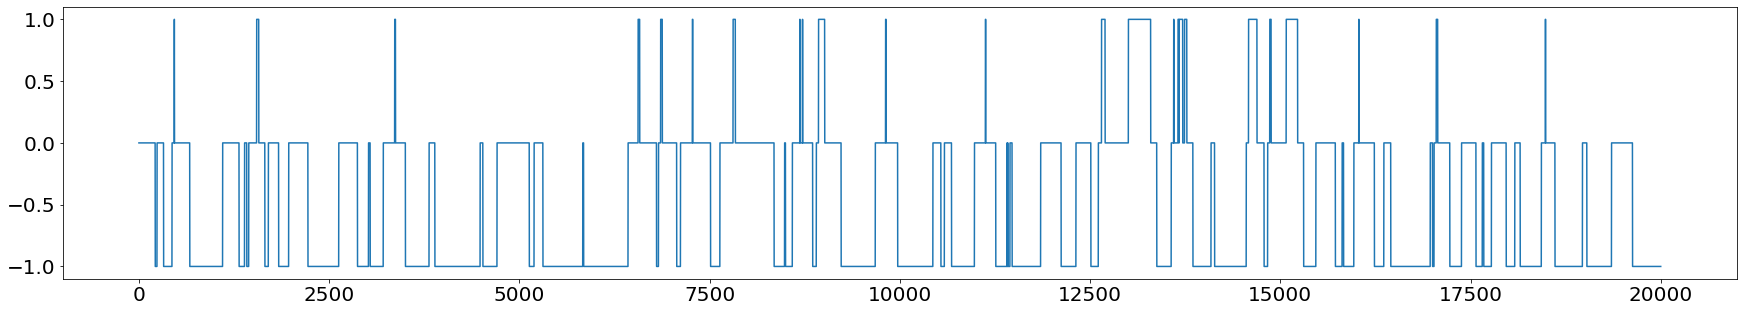

In [ ]:
plt.plot(reward)
plt.show()

(20000,)
0
[  214   215   216 ... 19997 19998 19999]
[[ 0.39592931  0.80036648]
 [ 0.40204692  0.80184496]
 [ 0.408099    0.80325695]
 ...
 [ 0.96178984 -0.98446816]
 [ 0.96190355 -0.98462562]
 [ 0.96201467 -0.9847817 ]]


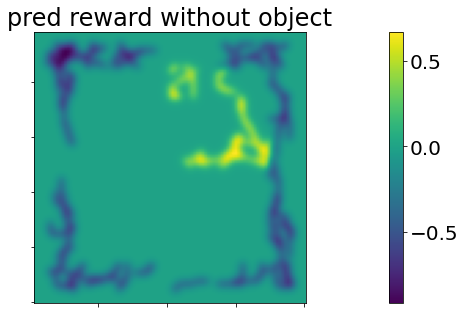

In [ ]:
#print(gt)
from scipy.ndimage import gaussian_filter
import scipy
from scipy import signal, ndimage
#ot = predicted_output[1][:,-1,:]
#ot = gt
# ot = np.ndarray.flatten(encoded['val'])
ot = reward
print(ot.shape)
thresh = np.min(ot)*0
print(thresh)
firr = np.nonzero(ot!=thresh)
print(firr[0])
#firr = np.nonzero(abs(resp_neurons[i+num])>thresh)
firposgrid = pos[firr[0], :]
print(firposgrid)
title = "pred reward without object"
firing_map = firing_rate_map(firposgrid, ot, firr, title)

### Images

In [ ]:
## opening images from file
# train_imgs = train_generator[0][0]
# with open(data_fol+"frames_traj(obj)_bw_20k.pk1", 'wb') as ff:
#     pickle.dump(train_imgs, ff)
#     ff.close()
    # 
with open(data_fol + imgs, "rb") as f:
    train_imgs = pickle.load(f)
    f.close()

# train_imgs = train_imgs[:-1]
print(train_imgs.shape)

# CREATING TEST AND TRAIN DATA-SET
# sub_imgs = test_train(train_imgs, test_p)
# sub_comp_gt = test_train(comp_gt, test_p)
# comp_gt2 = np.column_stack((pos[:-1], Hd_rep))
# sub_comp_gt2 = test_train(comp_gt2, 5)
# print(sub_imgs[0].shape)
# print(sub_imgs[1].shape)

(20000, 32, 32, 3)


### PI

In [ ]:
####--------------------- PI (WITHOUT OSCILLATORS)-------------------########
print(pi_use)
if pi_use == "no_osc":
  #%%Calculating distance from starting point
  print("------using PI WITHOUT oscillators-----")
  pos = np.column_stack((x,y))
  a = pos[0,0] * np.ones(pos[:,0].shape)
  b = pos[0,1] * np.ones(pos[:,1].shape)
  origin = np.transpose(np.append([a],[b],axis=0)) #for different x,y

  #origin = 0 * np.ones(pos.shape) #for same x,y
  disp = pos - origin


  # %% Head direciton parameters
  n = 100
  dth = np.divide(2*np.pi, n)
  theta_pref = np.arange(0, 2*np.pi, dth)
  pref_dir = np.transpose([np.cos(theta_pref), np.sin(theta_pref)])
  print(len(pos))
  #curr_dir = []
  #for i in range(len(theta_rad)):
  #    dir = np.repeat(theta_rad[i],100)
  #    curr_dir[i].append(np.cos(dir - theta_pref))
  hdi = preprocessing.normalize(np.cos(np.matlib.repmat(theta_pref, len(pos),1) - np.transpose((np.matlib.repmat(theta_rad[0:len(pos)],n, 1)))), norm='l2')

  #%% HD responses
  hd_resp = []
  for i in range(len(disp)):
      for j in range(len(pref_dir)):
          z = np.array(disp[i])
          dj = np.array(pref_dir[j])
          hd_resp.append(np.dot(z,dj))
  hd_resp = np.transpose(np.reshape(hd_resp, (len(disp),len(pref_dir))))

  #%% path integraion
  #beta = np.transpose(np.random.normal(9,2, size=(1,7)))
  # beta = np.arange(3,4,1)
  beta = [9]
  pi_layer_beta = [] 
  for i in range(len(beta)):
      #pi_layer_temp = np.concatenate((np.cos(beta[i] * hd_resp),np.sin(beta[i] * hd_resp)))
      #pi_layer_temp = np.concatenate((beta[i] * hd_resp,beta[i] * hd_resp))
      pi_layer_temp = np.sin(beta[i] * hd_resp)
      #pi_layer_temp = (beta[i]* hd_resp)
      pi_layer_beta.append((pi_layer_temp))
  pi_layer_beta = np.asarray(pi_layer_beta)
  pi_beta = pi_layer_beta[0]
  for i in range(len(beta) - 1):
      pi_beta = np.concatenate((pi_beta, pi_layer_beta[i+1]))
  pi_lay = pi_beta.T
  # sub_pi = test_train(pi, test_p)


##### ---------------------------- PI (WITH OSCILLATORS) ----------------------#########
if pi_use == "osc":
  print("-------- using PI WITH oscillators --------")
  trj_hd_resp = HD(speed, theta)
  #hd = np.asarray(trj_hd_resp)
  PI1d = PI(trj_hd_resp, speed)
  PI1d = np.transpose(PI1d)
  PI1d = preprocessing.normalize(PI1d, norm='l2', axis=1)

  hd_resp = [iii.T.reshape(100,1) for iii in trj_hd_resp]
  hd_resp = np.asarray(hd_resp).reshape(len(hd_resp), hd_resp[0].shape[0])
  hd_resp = preprocessing.normalize(hd_resp, norm='l2', axis=1)
  num_images = PI1d.shape[0]
  # d = {"CAdns1":CAdns1, "CAdns2":CAdns2, "PIdns1": PIdns1, "PIdns2":PIdns2, "Lecdns":Lecdns}
  # with open(fol+"PI.pk1", 'wb') as ff:
  #     pickle.dump(PI1d, ff)
  #     ff.close()

  # with open(fol + "PI.pk1", "rb") as f:
  #     PI1d = pickle.load(f)
  #     f.close()

  pi_lay = PI1d
  # sub_pi = test_train(pi, test_p)
# pi = pi[:-1]
from sklearn.model_selection import train_test_split

# sub_imgs = train_test_split(train_imgs, test_size=0.2, random_state=random_state)
# sub_pi = train_test_split(pi, test_size=0.2, random_state=random_state)
# sub_comp_gt = train_test_split(comp_gt, test_size=0.2, random_state=random_state)
# sub_r = train_test_split(reward, test_size=0.2, random_state=random_state)
# print(sub_imgs[0].shape, sub_pi[0].shape, sub_comp_gt[0].shape, sub_r[0].shape)

no_osc
------using PI WITHOUT oscillators-----
20000


---------------------------------
---------------------------------
---------------------------------
### Test train split

In [ ]:
# GENERATING DATA FOR LSTM
from sklearn.model_selection import train_test_split
seq_len = 1

pi_seq = seq_data(pi_lay, seq_len)
train_imgs_seq = seq_data(train_imgs, seq_len)
r_seq = seq_data(reward, seq_len)
print(train_imgs_seq.shape)

sub_imgs_seq = train_test_split(train_imgs_seq, test_size=0.2, random_state=random_state)
# sub_imgs = train_test_split(train_imgs, test_size=0.2, random_state=random_state)
sub_pi_seq = train_test_split(pi_seq, test_size=0.2, random_state=random_state)
# sub_pi = train_test_split(pi_lay, test_size=0.2, random_state=random_state)
# sub_r = train_test_split(reward, test_size=0.2, random_state=random_state)
sub_r_seq = train_test_split(r_seq, test_size=0.2, random_state=random_state)

# sub_comp_gt = train_test_split(comp_gt[:-1], test_size=0.2, random_state=random_state)

sub_pi_t = sub_pi_seq
sub_imgs_t = sub_imgs_seq
sub_r_t = sub_r_seq

print(sub_pi_t[0].shape, sub_pi_t[1].shape)
print(sub_imgs_t[0].shape, sub_imgs_t[1].shape)
# print(sub_comp_gt[0].shape, sub_comp_gt[1].shape)
print(sub_r_t[0].shape, sub_r_t[1].shape)

(19999, 1, 32, 32, 3)
(15999, 1, 100) (4000, 1, 100)
(15999, 1, 32, 32, 3) (4000, 1, 32, 32, 3)
(15999, 1) (4000, 1)


# MODEL

### Setup Architecture

In [ ]:
from keras.layers import Dropout, GlobalAveragePooling2D
from keras.regularizers import l2
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Dense, RNN, LSTM, SimpleRNN
from keras.layers import ConvLSTM2D, TimeDistributed, MaxPooling3D, Conv3D

#activity_regularizer=tf.keras.regularizers.l2(1)
# strides=(2,2)                            
if Train:
  print("#########-----------------TRAINING MODEL---------------#########")
  act = 'relu'


  input_img = Input((1, 32, 32, 3))
  input_pi = Input((1, 100))
  #input_pi = Input(shape = (1, 100))
  #input_img = Input(shape = (1, 32, 32, 3))
  encoder = Conv3D(8, (1, 5, 5), padding='same', activation= act, name="CONV_1")(input_img)
  encoder = MaxPooling3D(pool_size=(1,2,2), padding='same', name="MAXPOOL_1")(encoder)
  encoder = Conv3D(4, (1, 5, 5), padding='same', activation= act,name="CONV_2")(encoder)
  encoder = MaxPooling3D(pool_size=(1,2,2), padding='same', name="MAXPOOL_2")(encoder)
  encoder = Conv3D(2, (1, 5, 5), padding='same', activation= act,name="CONV_3")(encoder)
  encoder = MaxPooling3D(pool_size=(1,2,2), padding='same', name="MAXPOOL_3")(encoder)
  flatencoder=TimeDistributed(Flatten())(encoder) 
  #print(flatencoder.shape)
  dense0 = TimeDistributed(Dense(50, activation = 'sigmoid'), name='LEC')(flatencoder)
  #print(dense0.shape)
  dense_pi1 = TimeDistributed(Dense(50, activation= 'sigmoid'), name='MEC')(input_pi)
  #print(dense_pi1.shape)
  dense0 = layers.Reshape((1,1,50))(dense0)
  dense_pi1 = layers.Reshape((1,1,50))(dense_pi1)
  #print(dense0.shape, dense_pi1.shape)
  data_layer = layers.concatenate([dense0, dense_pi1], axis=1)
  #print(data_layer.shape)

  edge_layer = tf.constant(np.matlib.repmat(np.asarray([[1/3,1/3], [1/3,1/3]]), 1, 1).reshape((1,1,2,2)))
  # print (edge_layer.shape)
  conv_layer = GraphConv(units=50, step_num=1,)([data_layer, edge_layer])
  #print("conv_layer", conv_layer.shape)
  # conv_layer = layers.Reshape((1,2,50))(conv_layer)
  print("conv_layer_N", conv_layer.shape)
  # rnn_0 = RNN(FF(25), return_sequences=True, name = "LEC_LSTM", stateful = True, return_state = False)(conv_layer[0,:,:])
  # rnn_01 = RNN(FF(25), return_sequences=True, name = "LEC_LSTM1", stateful = True, return_state = False)(rnn_0)
  # rnn_1= RNN(FF(25), return_sequences=True, name = "MEC_LSTM", stateful = True, return_state = False)(conv_layer[1,:,:])
  # rnn_11 = RNN(FF(25), return_sequences=True, name = "MEC_LSTM1", stateful = True, return_state = False)(rnn_1)
  #print("rnn", rnn_0.shape),state_h11,state_c11
  #conv_layer = Dropout(0.5)(rnn_0)
  #temp_layer = layers.concatenate([conv_layer[:,0:1,:], rnn_0], axis = 1)
  # temp_layer = layers.concatenate([rnn_01, rnn_11], axis = 1)
  #print("temp_layer", temp_layer.shape)

  conv_layer0 = Flatten()(conv_layer)
  #print("conv_layer0", conv_layer0.shape)
  conv_layer0 = layers.Reshape((1,100))(conv_layer0)
  rnn = RNN(FF(50), return_sequences=False, name = "CA3_LSTM", stateful = False, return_state = False)(conv_layer0)
  #rnn = RNN(FF(100), return_sequences=False, name = "CA3_FF", stateful = False, return_state = False)(conv_layer0)
  # dense1 = Dense(50, activation= 'sigmoid', name='CA1')(rnn)
  output1 = Dense(1, activation='linear', name='VALUE1')(rnn)

  regressor_model = Model([input_img, input_pi], output1)

  opt = tf.keras.optimizers.Adam(learning_rate= 0.0001)
  regressor_model.compile(optimizer=opt, loss="mse", )
  regressor_model.summary()   

# plot_model(regressor_model, to_file=fol+'Max_model1_plot.png', show_shapes=True, show_layer_names=True)

### Train the model

In [ ]:
# Train the model 
# train_imgs = (train_imgs - 0.2)*3

if Train:
  model = regressor_model
  num_images = pos[0]-1
  # k = np.empty(())
  # print(k.shape)
  # if (to_do == "train") or (to_do == "both"):
  # for i in range(70): 
  # print("epoch no: " + str(i)) 
  # edge = np.asarray([[0,1], [1,0]])
  history = model.fit(
            [sub_imgs_t[0], sub_pi_t[0]],
            sub_r_t[0],
            epochs=5,
            batch_size=1,
            validation_data = ([sub_imgs_t[1], sub_pi_t[1]], sub_r_t[1]),
            shuffle = True)
  namm = "traj(wo)(col_obj)_simpletest_bw_20k"
  model.save(fol+ namm +".h5")


  hist_ = history.history
  with open(fol+"hist_" + namm + ".pk1", 'wb') as ff:
      pickle.dump(hist_, ff)
      ff.close()

  kk = str(len(pos))
  plt.plot(hist_["loss"], "-r", label = "loss")
  plt.plot(hist_["val_loss"], "--b", label = "val_loss")
  plt.legend()
  plt.title("training 1 without objects "+kk)
  plt.show()


### Retrain The model

(20000, 32, 32, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 32, 32,   0           []                               
                                3)]                                                               
                                                                                                  
 CONV_1 (Conv3D)                (None, 1, 32, 32, 8  608         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 MAXPOOL_1 (MaxPooling3D)       (None, 1, 16, 16, 8  0           ['CONV_1[0][0]']                 
                                )                                          

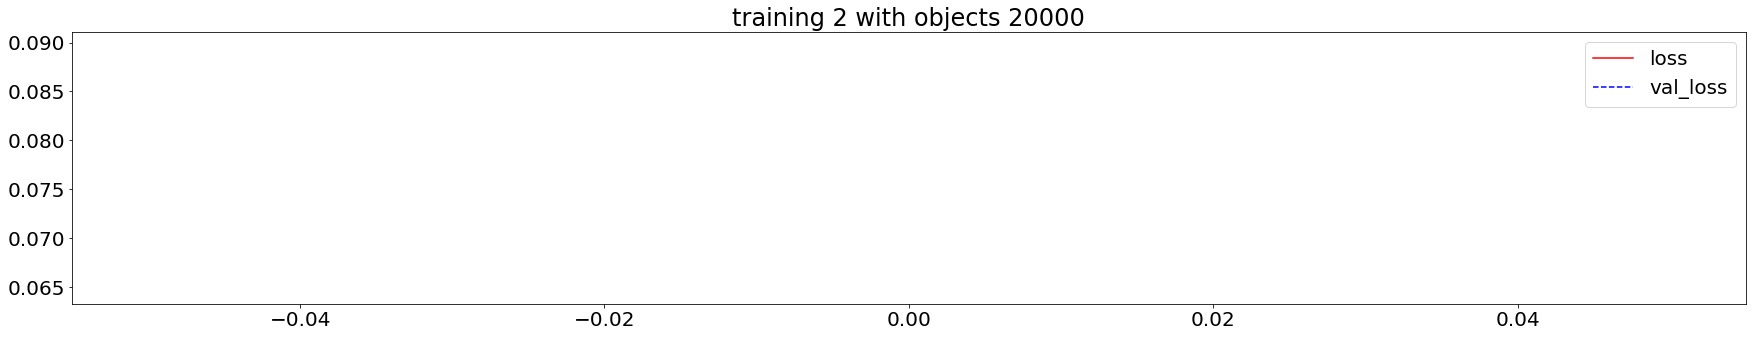

In [ ]:
if Retrain:  
  print(train_imgs.shape)
  # from keras_gcn import GraphConv

  model = tf.keras.models.load_model(fol+"re_traj(col_obj)_simpletest_bw_20k.h5", custom_objects = {"GraphConv": GraphConv, "FF":FF})
  opt = tf.keras.optimizers.Adam(learning_rate= 0.0001)
  model.compile(loss='mse', optimizer=opt)
  model.summary()
  
  # Retrain the model
  num_images = pos[0]-1
  loss = []
  val_loss = []
  history = model.fit(
            [sub_imgs_t[0], sub_pi_t[0]],
            sub_r_t[0],
            epochs=1,
            batch_size=1,
            validation_data = ([sub_imgs_t[1], sub_pi_t[1]], sub_r_t[1]),
            shuffle = True)
  
  namm = "re_traj(col_obj)(sh1)_simpletest_bw_20k"  
  model.save(fol+ namm +".h5")

  # save history
  hist_ = history.history
  with open(fol+"hist_" + namm + ".pk1", 'wb') as ff:
      pickle.dump(hist_, ff)
      ff.close()

  kk = str(len(pos))
  plt.plot(hist_["loss"], "-r", label = "loss")
  plt.plot(hist_["val_loss"], "--b", label = "val_loss")
  plt.legend()
  plt.title("training 2 with objects "+kk)
  plt.show()

# LAYERWISE OUTPUT ANALYSIS

#### Save & load layerwise output

In [ ]:
if Analysis: 
  # from keras_gcn import GraphConv 
  # namm = []
  if (not Train) and (not Retrain):
    namm = "re_traj(col_obj)(sh1)_simpletest_bw_20k"
  autoencoder_model = tf.keras.models.load_model(fol+ namm +".h5", custom_objects = {"GraphConv": GraphConv, "FF": FF})
  outputs  = [layer.output for layer in autoencoder_model.layers]

  encoded = {}
  # encoded['val'] = autoencoder_model.predict([train_imgs, pi_lay])

MEC data is calculated.
(19999, 1, 50)
LEC data is calculated.
(19999, 1, 50)
0.4918644
0.089927256
0.9801195


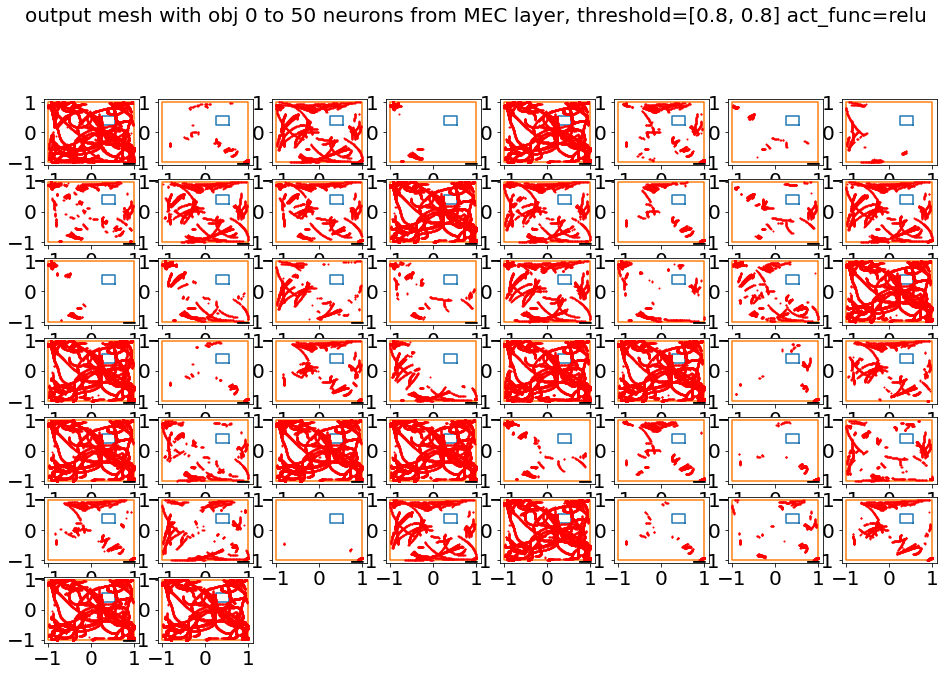

0.48956668
0.30846226
0.9998159


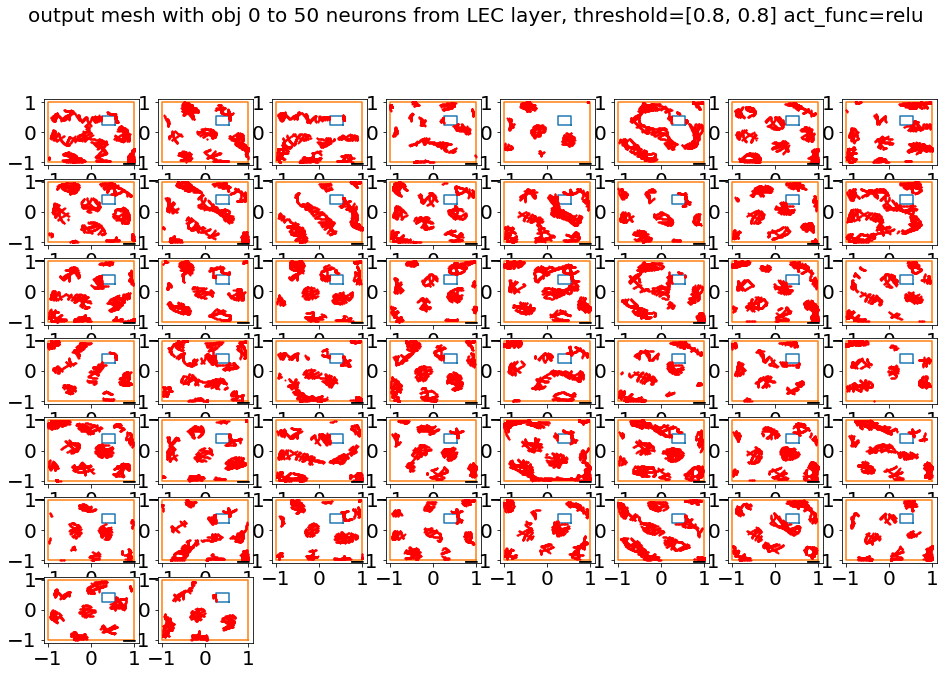

In [ ]:
# GET OUTPUT FOR THE REQUIRED LAYERS
if pre_conv:
  import keras_bert
  inp = autoencoder_model.input
  layers = ['LEC', 'MEC']#, 'CA1']# 'graph_conv']
  lay_nam = ['MEC', 'LEC']#, 'CA1']#, 'graph_conv']

  encoded_pre = {}

  for i in range(len(layers)):
    layer_output = autoencoder_model.get_layer(layers[i]).output
    # layer_output.shape
    functor = K.function(inp, layer_output)
    temp1 = functor([train_imgs_seq, pi_seq])
    print(lay_nam[i]+ " data is calculated.")
    print(temp1.shape)
    encoded_pre[lay_nam[i]] = temp1


  from matplotlib.pyplot import close
  outs = [encoded_pre["MEC"], encoded_pre['LEC']]#, encoded['CA1']]#, encoded['CA3']]
  lim = [0.8, 0.8]
  outs_n = ["MEC", "LEC"]#, 'CA1']#, "CA1", "CA3"]
  pos_out = pos

  for k in range(len(outs)):
      resp_neurons = np.squeeze(np.transpose(outs[k]))
      avg = np.mean(abs(resp_neurons))
      std_dev = np.std(resp_neurons)
      print(avg)
      print(std_dev)
      m = np.amax(resp_neurons)
      print(m)
      num = 0
      for j in range(int(np.divide(len(resp_neurons),50))):
          onm = outs_n[k]
          for i in range(50):
              plt.subplot(7,8,i+1)
              thresh = np.amax(resp_neurons[i+num]) * lim[k]
              # thresh = 0
              # thresh = avg + 2*std_dev
              firr = np.nonzero(resp_neurons[i+num]>thresh)
              firposgrid = pos_out[firr[0], :]
              # plt.scatter(pos[:,0], pos[:,1])
              plt.scatter(firposgrid[:,0], firposgrid[:,1], s = 1, color = 'red', marker='o', zorder = 5)
              for tt in obj:
                plt.plot(tt[0], tt[1])
              plt.plot(env[0], env[1])
              plt.suptitle('output mesh with obj '+str(num)+ ' to '+str(num+50)+' neurons from '+ onm +' layer, threshold=' +str(lim)+" act_func=" + "relu", fontsize = 20, va = 'bottom', ha = 'center')

          figure = plt.gcf() # get current figure
          figure.set_size_inches(16, 10)
          plt.show()
          close()
          num = num + 50

In [ ]:
if Analysis:
  # GET OUTPUT FOR THE REQUIRED LAYERS
  import keras_bert
  # autoencoder_model = regressor_model
  inp = autoencoder_model.input
  layy = 'graph_conv'
  # layers = ['dense', 'dense_1', 'dense_2', 'dense_4']
  layers = [layy, 'CA3_LSTM']
  # lay_nam = ['CA3', 'LEC', 'MEC', 'CA1', 'val']
  # layers = ['LEC', 'CA']
  lay_nam = [layy, 'CA3_LSTM']
  # train_imgs = train_imgs[:-1]
  # encoded = {}
  tes = 1
  j1 = train_imgs_seq.shape[0]//tes
  j2 = train_imgs_seq.shape[0]%tes
  print(j1)
  print(j2)
  for i in range(len(layers)):
    layer_output = autoencoder_model.get_layer(layers[i]).output
    layer_output
    functor = K.function(inp, layer_output)
    # temp1 = functor(train_imgs)
    for jj in range(1,j1+1):
      if jj == 1:
        if layers[i] == layy:
          temp1 = np.squeeze(functor([train_imgs_seq[tes*(jj-1):tes*jj], pi_seq[tes*(jj-1):tes*jj]]))
          temp_LEC = temp1[0,:]
          temp_MEC = temp1[1,:]
        else:
          temp1 = np.squeeze(functor([train_imgs_seq[tes*(jj-1):tes*jj], pi_seq[tes*(jj-1):tes*jj]]))

      else:
        if layers[i] == layy:
          temp1 = np.squeeze(functor([train_imgs_seq[tes*(jj-1):tes*jj], pi_seq[tes*(jj-1):tes*jj]]))
          temp_LEC = np.vstack((temp_LEC, temp1[0,:]))
          temp_MEC = np.vstack((temp_MEC, temp1[1,:]))
          if not jj%2000:
            print(jj)
        else:
          temp1 = np.vstack((temp1, np.squeeze(functor([train_imgs_seq[tes*(jj-1):tes*jj], pi_seq[tes*(jj-1):tes*jj]]))))
          if not jj%2000:
            print(jj)
    if j2!=0:
      temp1 = np.vstack((temp1, np.squeeze(functor([train_imgs_seq[tes*j1:], pi_seq[tes*j1:]])[:,seq_len-1,:])))

    print(lay_nam[i]+ " data is calculated.")
    print(temp1.shape)
    encoded["CA3_LSTM"] = temp1
    encoded["LEC"] = temp_LEC
    encoded["MEC"] = temp_MEC

19999
0
2000
4000
6000
8000
10000
12000
14000
16000
18000
graph_conv data is calculated.
(2, 50)
2000
4000
6000
8000
10000
12000
14000
16000
18000
CA3_LSTM data is calculated.
(19999, 50)


In [ ]:
plt.rcParams['figure.figsize'] = [30,5]
# plt.plot(reward)
# plt.plot(np.ndarray.flatten(encoded["val"]))
# # plt.plot(abs(encoded["MEC"][:,2]))
# plt.show()

#### Plotting layer wise output

0.374503
0.43821785
1.6073925


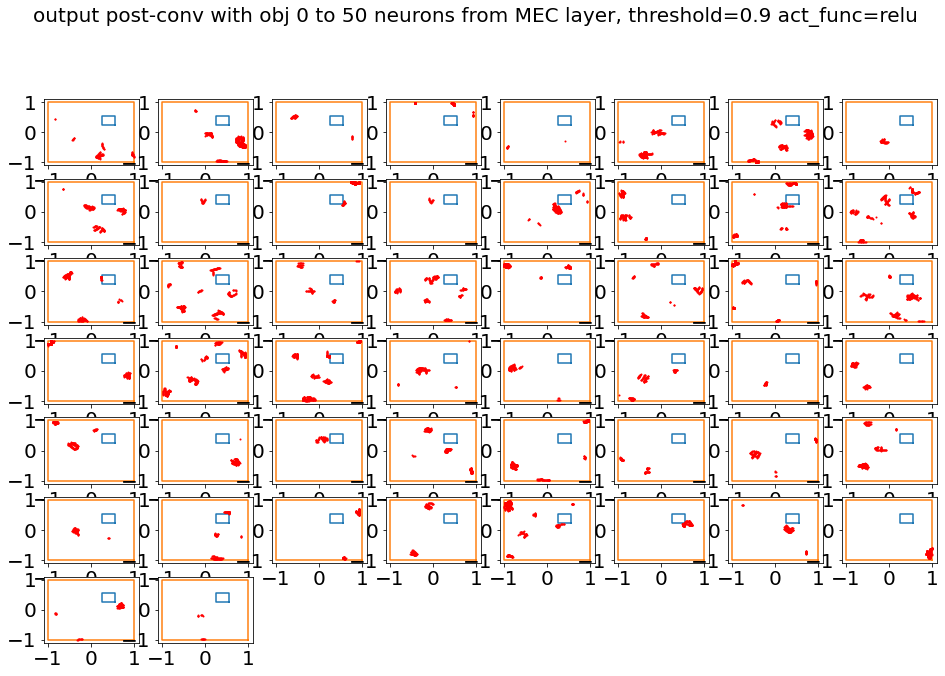

0.2817193
0.32488385
1.3383377


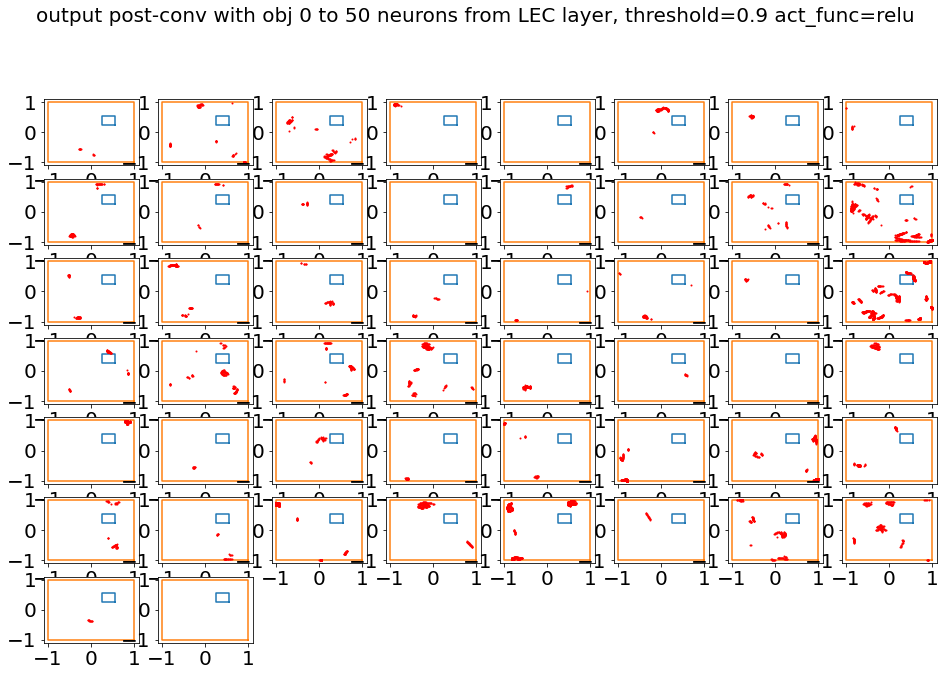

0.5023711
0.1759686
0.95213455


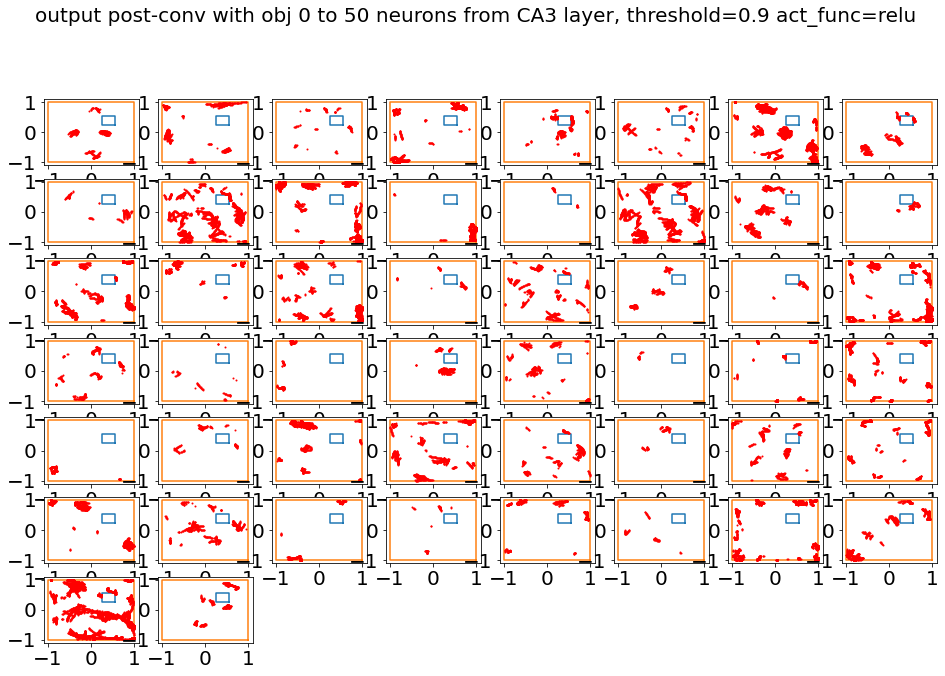

In [ ]:
if Analysis:
  from matplotlib.pyplot import close
  # lim = 0.5
  outs = [encoded["MEC"], encoded['LEC'], encoded['CA3_LSTM']]#, encoded['CA3']]
  lim = [0.9, 0.9, 0.9]
  outs_n = ["MEC", "LEC", "CA3"]
  pos_out = pos

  for k in range(len(outs)):
      resp_neurons = np.transpose(outs[k])
      avg = np.mean(abs(resp_neurons))
      std_dev = np.std(resp_neurons)
      print(avg)
      print(std_dev)
      m = np.amax(resp_neurons)
      print(m)
      num = 0
      for j in range(int(np.divide(len(resp_neurons),50))):
          onm = outs_n[k]
          for i in range(50):
              plt.subplot(7,8,i+1)
              thresh = np.amax(resp_neurons[i+num]) * lim[k]
              # thresh = 0
              # thresh = avg + 2*std_dev
              firr = np.nonzero(resp_neurons[i+num]>thresh)
              firposgrid = pos_out[firr[0], :]
              # plt.scatter(pos[:,0], pos[:,1])
              plt.scatter(firposgrid[:,0], firposgrid[:,1], s = 1, color = 'red', marker='o', zorder = 5)
              for tt in obj:
                plt.plot(tt[0], tt[1])
              plt.plot(env[0], env[1])
              plt.suptitle('output post-conv with obj '+str(num)+ ' to '+str(num+50)+' neurons from '+ onm +' layer, threshold=' +str(lim[k])+" act_func=" + "relu", fontsize = 20, va = 'bottom', ha = 'center')

          figure = plt.gcf() # get current figure
          figure.set_size_inches(16, 10)
          plt.show()
          close()
          num = num + 50

------------------------------


------------------------------


------------------------------

0


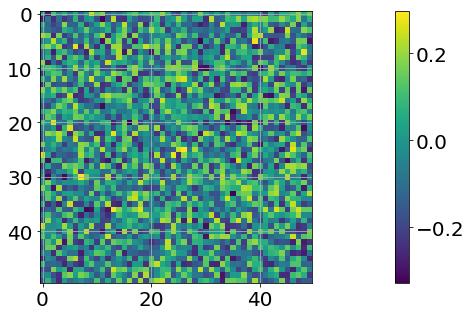

In [ ]:
from pylab import *
layer_weight = autoencoder_model.get_layer("graph_conv").get_weights()
A = layer_weight[0]
figure(1)
imshow(A)
colorbar()
grid(True)
print(np.count_nonzero(A == 0))

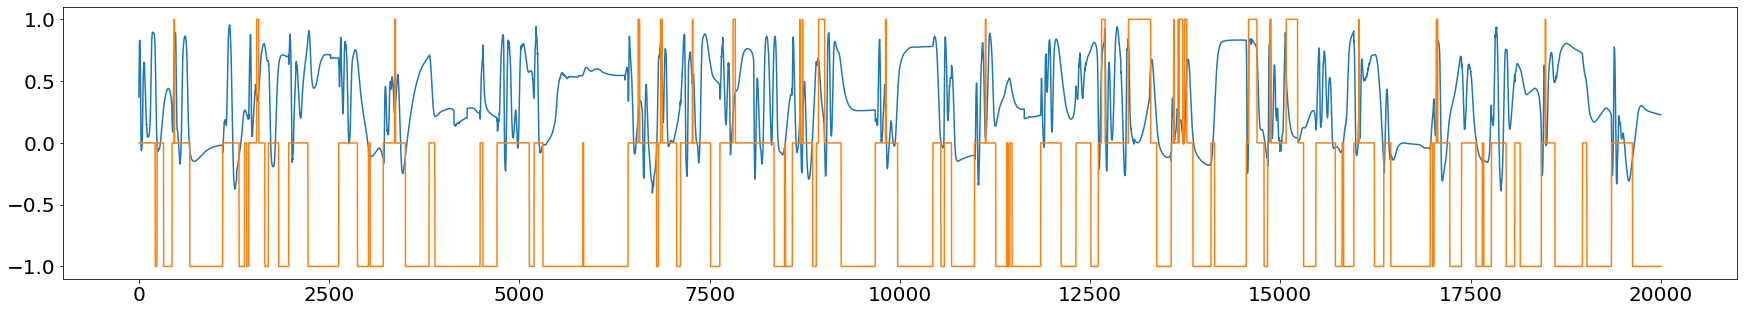

In [ ]:
plt.rcParams['figure.figsize'] = [30,5]
plt.rcParams['font.size'] = 20
plt.plot(encoded["MEC"][:,17])
plt.plot(reward)
plt.show()
close()

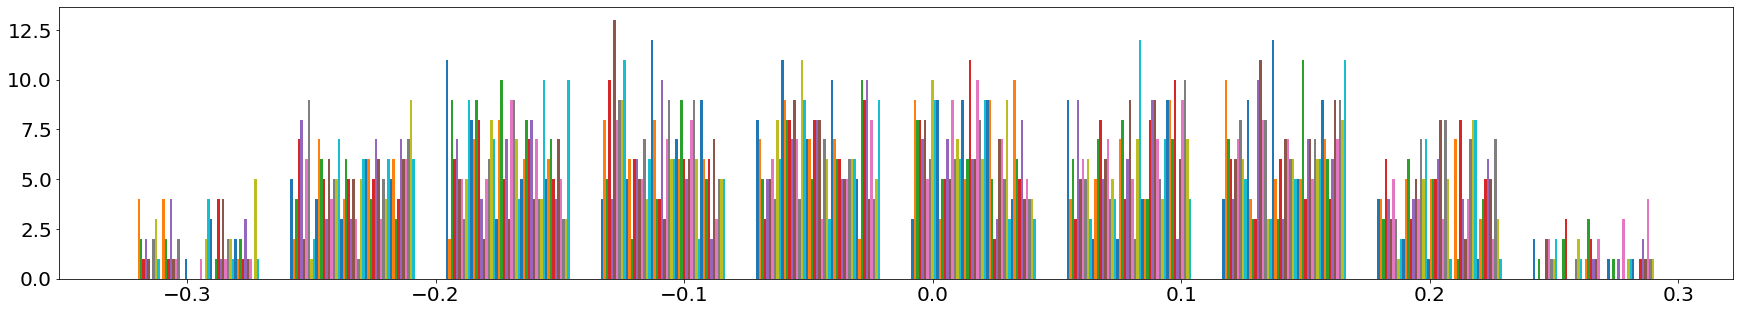

In [ ]:
A.reshape(1,2500)
plt.hist(A)
plt.show()